## <span style="color:blue">1. Library Imports</span>

In [36]:
import yaml
import numpy as np
import pandas as pd
from IPython.display import display

import re
from collections import defaultdict

from dash import Dash, dcc, html
import plotly.express as px

## <span style="color:blue">2. Load Data </span>
* **asset.yaml:** This is a file with keywords for trading signals and different asset classes. Obviously while connecting with Bloomberg terminal to fetch data this file won't be needed - we might need only a list of keywords.
* **IBM_messages:** I had a look on the IB chat of my Bloomberg account yesterday in the trading floor of my university. Even though I was not able to access any group chat (probably because they are private), I did send a few messages to understand the structure/fields of the chat and I generated 500 random messages.

In [37]:
def load_yaml(filename="assets.yaml"):
    """
    Read yaml file
    """
    with open(filename, "r") as file:
        return yaml.safe_load(file)
    

assets = load_yaml()

# Extract different asset categories
trading_signals = assets.get("trading_signals", [])
currencies = assets.get("currencies", [])
stocks = assets.get("stocks", [])
indices = assets.get("indices", [])
commodities = assets.get("commodities", [])
fixed_income = assets.get("fixed_income", [])

In [38]:
# Load the IB chat messages dataset
df = pd.read_csv("IB_messages.csv")
display(df.head(3))

,Timestamp,Username,Message
0,07/03/2025 10:06:41,Teresa,"Not sure about DAX40 today, but data comes out..."
1,07/03/2025 10:48:31,Johnny FX_JPM,Bearish Apple
2,07/03/2025 10:19:35,Stefanie,I’m seeing strong buying pressure Amazon


## <span style="color:blue"> 3. Message Filtering </span>
* **Format**: Bring all text to the same format
* **Split to groups (clusters)**: Assign each text to an asset class, a pair/symbol and a trading signal
* **Remove noisy data**: Texts that do not have pair/symbol or a trading signal drop them. This reduces the non-sense messages (e.g., hi, how is everyone today... any ideas on what the FED might do...)

In [39]:
def clean_text(text):
    """
    Convert text to lower and remove special characters
    """
    text = text.lower()  
    text = re.sub(r'[^a-zA-Z0-9\s/$]', '', text)
    return text

# Apply cleaning function
df["Cleaned_Message"] = df["Message"].apply(clean_text)

display(df[["Message", "Cleaned_Message"]].head())

,Message,Cleaned_Message
0,"Not sure about DAX40 today, but data comes out...",not sure about dax40 today but data comes out ...
1,Bearish Apple,bearish apple
2,I’m seeing strong buying pressure Amazon,im seeing strong buying pressure amazon
3,SHORT Gold,short gold
4,Thinking about lightening my exposure to Nvidi...,thinking about lightening my exposure to nvidi...


In [40]:
def extract_signal(message):
    words = message.lower().split()
    
    # Find trading signal
    signal = next((word.upper() for word in words if word in trading_signals), None)
    
    # Find asset and its class
    asset, asset_class = None, None
    for word in words:
        if word in currencies:
            asset, asset_class = word.upper(), "FX"
            break
        elif word in stocks:
            asset, asset_class = word.capitalize(), "Stock"
            break
        elif word in indices:
            asset, asset_class = word.upper(), "Index"
            break
        elif word in commodities:
            asset, asset_class = word.capitalize(), "Commodity"
            break
        elif word in fixed_income:
            asset, asset_class = word.upper(), "Fixed Income"
            break

    return signal, asset, asset_class

# Reduce data dimensionality by dropping not needed col
df.drop(columns=['Message'], inplace=True)

# Apply function to text msg
df[["Signal", "Asset", "Asset_Class"]] = df["Cleaned_Message"].apply(lambda x: pd.Series(extract_signal(x)))
display(df.head())

,Timestamp,Username,Cleaned_Message,Signal,Asset,Asset_Class
0,07/03/2025 10:06:41,Teresa,not sure about dax40 today but data comes out ...,None,DAX40,Index
1,07/03/2025 10:48:31,Johnny FX_JPM,bearish apple,BEARISH,Apple,Stock
2,07/03/2025 10:19:35,Stefanie,im seeing strong buying pressure amazon,None,Amazon,Stock
3,07/03/2025 10:28:54,Mary,short gold,SHORT,Gold,Commodity
4,07/03/2025 10:35:15,Brittany,thinking about lightening my exposure to nvidi...,None,Nvidia,Stock


In [41]:
# Remove all noisy texts
df = df.dropna(subset=['Signal', 'Asset'])
df.reset_index(drop=True, inplace=True)
display(df.head())

,Timestamp,Username,Cleaned_Message,Signal,Asset,Asset_Class
0,07/03/2025 10:48:31,Johnny FX_JPM,bearish apple,BEARISH,Apple,Stock
1,07/03/2025 10:28:54,Mary,short gold,SHORT,Gold,Commodity
2,07/03/2025 10:11:54,Emily,bearish ftse100,BEARISH,FTSE100,Index
3,07/03/2025 10:17:13,Shawn,short apple,SHORT,Apple,Stock
4,07/03/2025 10:21:35,Phillip,bullish gbp/usd including style go those stude...,BULLISH,GBP/USD,FX


## <span style="color:blue"> 4. Generated Signals and Confidence </span>
* **Signals**: Based on all the keywords, now categorize the signals only to BUY and SELL
* **Confidence**: Create a custom confidence interval

In [42]:
# Define signal mappings
buy_signals = ["buy", "long", "bullish", "breakout", "support"]
sell_signals = ["sell", "short", "bearish", "resistance"]

# Initialize a dictionary to count occurrences of BUY and SELL only
confidence_scores = defaultdict(int)

# Iterate over the dataframe
for _, row in df.dropna(subset=["Signal"]).iterrows():
    signal = row["Signal"].lower()  # Convert signal to lowercase
    asset = row["Asset"]
    
    # Map different words to either BUY or SELL
    if signal in buy_signals:
        key = ("BUY", asset)
    elif signal in sell_signals:
        key = ("SELL", asset)
    else:
        continue  # Skip signals that are not BUY or SELL related

    # Increment the count for confidence calculation
    confidence_scores[key] += 1

# Convert dictionary to DataFrame
confidence_df = pd.DataFrame([(k[0], k[1], v) for k, v in confidence_scores.items()], 
                             columns=["Signal", "Asset", "Confidence"])

# Normalize confidence score
confidence_df["Confidence"] = 1 - (2.71 ** (-0.1 * confidence_df["Confidence"]))

# Sort by confidence
confidence_df = confidence_df.sort_values("Confidence", ascending=False)
confidence_df.reset_index(drop=True, inplace=True)
print(display(confidence_df))

,Signal,Asset,Confidence
0,BUY,Gold,0.592312
1,BUY,Silver,0.549573
2,BUY,DAX40,0.502353
3,BUY,NASDAQ100,0.502353
4,SELL,DAX40,0.450183
5,SELL,FTSE100,0.450183
6,BUY,Netflix,0.450183
7,SELL,Tesla,0.392543
8,BUY,EUR/GBP,0.392543
9,SELL,EUR/GBP,0.328861


None


## <span style="color:blue"> 5. Final Analysis </span>
* **Aggregate Pairs**: Based on the dataframe above, there might be text from users where they suggest BUY Gold and others SELL Gold. Take their absolute difference and display a final signal.
* **Confidence Threshold**: Set the confidence interval threshold at 0.1 (display only signals with higher than 10% probability)

In [45]:
# Pivot table to calculate total confidence for BUY and SELL per asset
pivot_df = confidence_df.pivot_table(index="Asset", columns="Signal", values="Confidence", aggfunc=np.sum, fill_value=0)

# Compute absolute difference and final signal
pivot_df["Final_Signal"] = np.where(pivot_df["BUY"] > pivot_df["SELL"], "BUY", "SELL")
pivot_df["Final_Confidence"] = abs(pivot_df["BUY"] - pivot_df["SELL"])

# Reset index to bring Asset back as a column
final_confidence_df = pivot_df[["Final_Signal", "Final_Confidence"]].reset_index()
final_confidence_df.columns = ["Asset", "Signal", "Confidence"]

# Sort by confidence
final_confidence_df = final_confidence_df.sort_values("Confidence", ascending=False).reset_index(drop=True)
# Ensure confidence values greater than 0.1 are displayed
filtered_final_confidence_df = final_confidence_df[final_confidence_df["Confidence"] > 0.1]
# Round conf interval
filtered_final_confidence_df = filtered_final_confidence_df.assign(Confidence=filtered_final_confidence_df['Confidence'].round(2))
# Display df
filtered_final_confidence_df

,Asset,Signal,Confidence
0,Silver,BUY,0.29
1,Gold,BUY,0.26
2,Netflix,BUY,0.19
3,Google,SELL,0.18
4,NASDAQ100,BUY,0.17
5,Amazon,SELL,0.16
6,USD/JPY,BUY,0.15
7,USD/CAD,SELL,0.15
8,FTSE100,SELL,0.12


## <span style="color:blue"> 5. Result </span>
* **Output**: A simple table like the one below could display signals constantly at the top right corner of a PM or Trader desktop (and updating in real-time).

In [13]:
df = filtered_final_confidence_df

# Initialize Dash app
app = Dash(__name__)

# Create a bar chart for confidence scores
fig = px.bar(df, x="Asset", y="Confidence", color="Signal",
             title="Trade Signals Confidence",
             labels={"Confidence": "Confidence Score", "Asset": "Trading Asset"},
             text_auto=True)

# Layout for the dashboard
app.layout = html.Div(children=[
    html.H1(children="Real-Time Trade Signal Dashboard"),
    
    # Display DataTable
    dash_table.DataTable(
        id="trade-table",
        columns=[{"name": i, "id": i} for i in df.columns],
        data=df.to_dict("records"),
        style_table={"overflowX": "auto"},
        style_cell={"textAlign": "center"},
    ),

    # Display confidence graph
    dcc.Graph(id="confidence-graph", figure=fig)
])

# Run the dashboard
if __name__ == "__main__":
    app.run_server(debug=True)


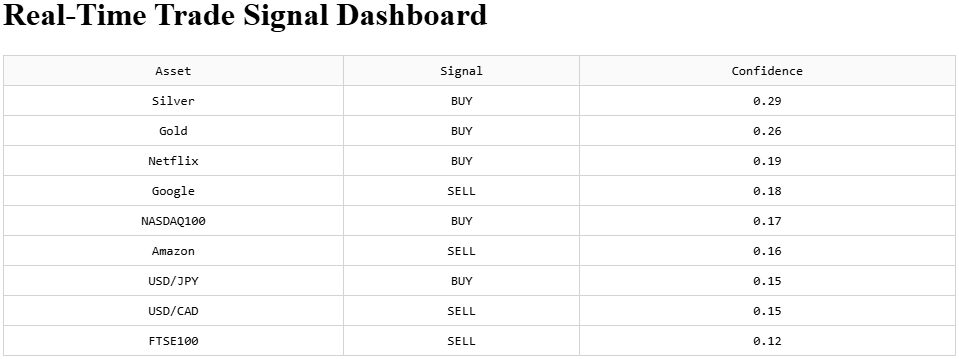
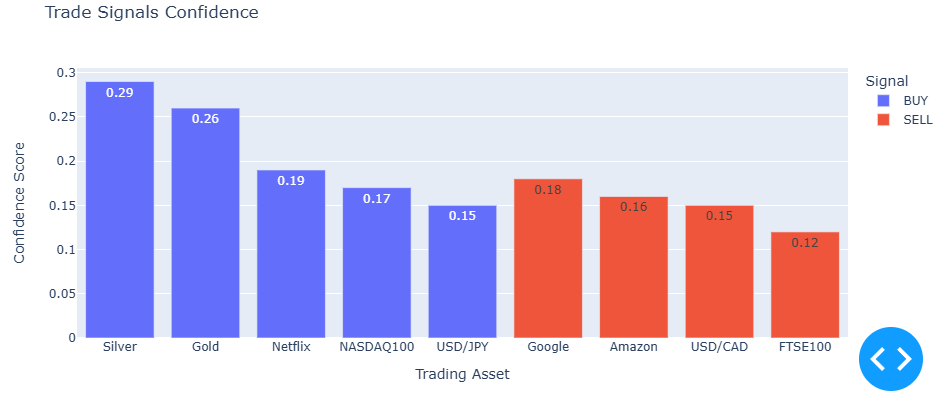

## <span style="color:blue"> 6. Few final words </span>
This high-level prototype was designed to extract trading signals from unstructured text messages without applying an Large Language Model (LLM). The reason for this is that LLMs require more time (while I spent only a day) and computational resources, making this lightweight NLP-based approach a good fit due to time-constraints. 

From **<span style="color:green">500 chat messages</span>**, which often contain noise and irrelevant discussions, the system successfully filtered and **grouped key trading signals**, resulting in **<span style="color:green">9 trade insights</span>**. In a few words, while you might not have time to read 500 messages, this program filters, groups and displays signals in a quick way. This system can read new messages, analyze them and can update the real time signals (or table) within ms.

### Things to improve
* **Message format:** This is clearly just an NLP algo (only text) but it could be expanded beyond text (e.g., get signals from PDFs and tables)
* **Data:** Data retrieval and dataset structure should be carefully planned to ensure efficiency, scalability, and accuracy.
* **Confidence Interval / Probability of Signal:** Above I have created a quick custom confidence interval without settings weights on features and without analysing the signals from these users (e.g., whether signals from specific users have been valid in the past, thus higher probability to be right again).
* **Extra fields:** Add an extra field such as Short-Term or Long-Term trade.
* **LLM integration:** ML/Deep Learning could enhance context understanding, and provide deeper market sentiment analysis.  
* **Layout:** As a final step, a customizable layout can be designed based on feedback from PMs and Traders, so the interface aligns with their workflow.
* **Further improvements:** The above are only some of the most important areas that need to be improved; as there is some progress with the project, new opportunities and difficulties will be presented, requiring constant innovation.